神经网络算法-相分类器

- 数据导入，处理为张量

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_excel("Phase_clean_data.xlsx", sheet_name="Sheet1")
y = df[["FCC", "BCC", "IM", "AM"]].values  # 目标标签
X = df.drop(["FCC", "BCC", "IM", "AM"], axis=1).values  # 特征

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 转换为Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 创建DataLoader（批量加载数据）
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [3]:
import numpy as np

# 计算类别权重
class_counts = np.sum(y_train, axis=0)  #axis=0,行方向压缩数组求和
class_weights = 1.0 / class_counts
class_weights = class_weights / np.sum(class_weights)
weights = torch.tensor(class_weights, dtype=torch.float32)
print(weights)

tensor([0.0331, 0.0367, 0.0402, 0.8901])


- 定义3个对象

In [4]:
import torch.nn as nn
import torch.optim as optim

# 定义模型
class phaseclassifier(nn.Module):
    def __init__(self, input_size, output_size):   #网络结构
        super(phaseclassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.out = nn.Linear(64, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):          #正向传播
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.out(x)
        return self.sigmoid(x)
    
# 初始化模型
model = phaseclassifier(input_size=X_train.shape[1],output_size=y_train.shape[1])     #输入维度（特征数量）,输出维度（预测标签数）
print(model)


# 定义损失函数与优化器
criterion = nn.BCELoss(weight=weights)  # 二元交叉熵损失，根据类别频率调整权重
optimizer = optim.Adam(model.parameters(),  #修改所有参数
                        lr=0.001            #学习率
                      )           

phaseclassifier(
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=64, out_features=4, bias=True)
  (sigmoid): Sigmoid()
)


- 定义训练过程

In [5]:

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    no_improve_epochs = 0
    
    for epoch in range(epochs):
        # 训练阶段
        model.train()
        sum_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            sum_train_loss += loss.item() * inputs.size(0)
        
        avg_train_loss = sum_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # 验证阶段
        model.eval()
        sum_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                sum_val_loss += loss.item() * inputs.size(0)
        
        avg_val_loss = sum_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        # 早停判断
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"早停步 epoch= {epoch+1}")
                break
        
        # 打印日志
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    print("训练完成")
    return train_losses, val_losses


- 网格搜索早停防止过拟合

In [6]:

# 保存初始模型和优化器状态
original_state = model.state_dict()
original_optimizer = optimizer  # 保存优化器配置

# 定义网格搜索参数
patience_values = [5, 10, 15, 20, 25]
best_overall_val_loss = float('inf')
best_patience = None
best_model_state = None

# 在原网格搜索循环中添加记录保存：
patience_results = []  # 在循环前初始化


for patience in patience_values:
    print(f"=== 网格搜索 patience={patience} ===")
    
    # 重置模型和优化器状态
    model.load_state_dict(original_state)
    optimizer = type(original_optimizer)(model.parameters(), **original_optimizer.defaults)
    
    # 训练模型
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=250, patience=patience)
    
    # 获取当前最佳验证损失和模型参数
    current_best_val_loss = min(val_losses)
    current_model_state = torch.load('best_model.pth')  # 读取保存的最佳模型
    
    # 更新全局最佳结果
    if current_best_val_loss < best_overall_val_loss:
        best_overall_val_loss = current_best_val_loss
        best_patience = patience
        best_model_state = current_model_state


    # 保存完整记录
    patience_results.append({
        'patience': patience,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': current_best_val_loss
    })
    
# 保存最终最佳模型
torch.save(best_model_state, 'best_model_grid_search.pth')
print(f"\n最佳 patience: {best_patience} validation loss: {best_overall_val_loss:.4f}")

# 加载最佳模型进行后续使用
model.load_state_dict(best_model_state)

=== 网格搜索 patience=5 ===
Epoch 1/250 | Train Loss: 0.1632 | Val Loss: 0.1418
Epoch 2/250 | Train Loss: 0.1192 | Val Loss: 0.0923
Epoch 3/250 | Train Loss: 0.0711 | Val Loss: 0.0539
Epoch 4/250 | Train Loss: 0.0451 | Val Loss: 0.0452
Epoch 5/250 | Train Loss: 0.0398 | Val Loss: 0.0429
Epoch 6/250 | Train Loss: 0.0373 | Val Loss: 0.0411
Epoch 7/250 | Train Loss: 0.0371 | Val Loss: 0.0385
Epoch 8/250 | Train Loss: 0.0348 | Val Loss: 0.0366
Epoch 9/250 | Train Loss: 0.0338 | Val Loss: 0.0348
Epoch 10/250 | Train Loss: 0.0323 | Val Loss: 0.0329
Epoch 11/250 | Train Loss: 0.0310 | Val Loss: 0.0310
Epoch 12/250 | Train Loss: 0.0299 | Val Loss: 0.0297
Epoch 13/250 | Train Loss: 0.0287 | Val Loss: 0.0285
Epoch 14/250 | Train Loss: 0.0276 | Val Loss: 0.0276
Epoch 15/250 | Train Loss: 0.0269 | Val Loss: 0.0267
Epoch 16/250 | Train Loss: 0.0259 | Val Loss: 0.0257
Epoch 17/250 | Train Loss: 0.0250 | Val Loss: 0.0253
Epoch 18/250 | Train Loss: 0.0246 | Val Loss: 0.0247
Epoch 19/250 | Train Loss: 0.02

<All keys matched successfully>

- 画图

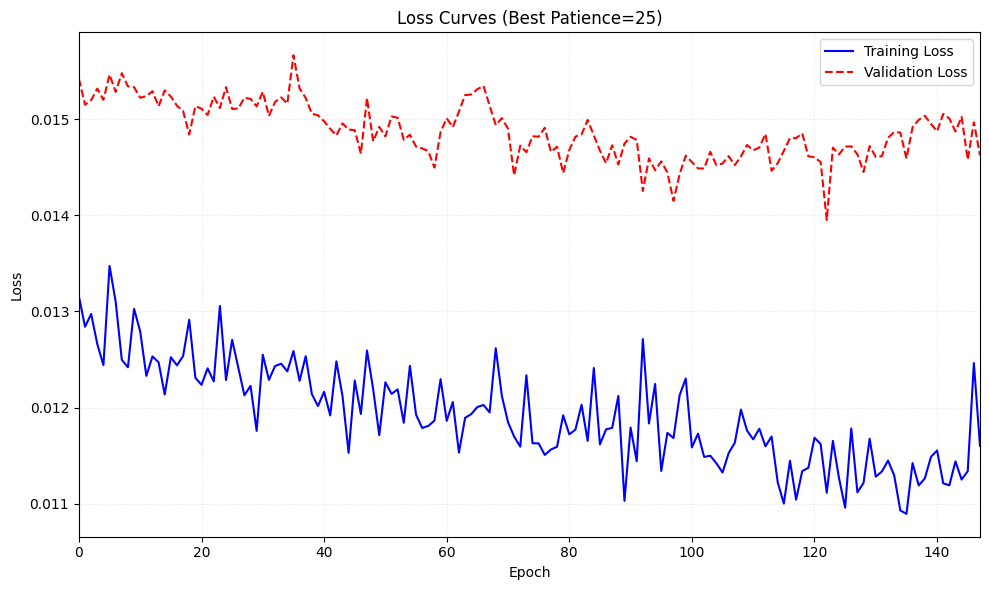

In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, val_losses, best_patience):
    plt.figure(figsize=(10, 6))
    
    # 绘制训练损失（实线）
    plt.plot(train_losses, 
             label='Training Loss',
             linestyle='-',
             color='blue',
            )
    
    # 绘制验证损失（虚线）
    plt.plot(val_losses,
             label='Validation Loss',
             linestyle='--',
             color='red'
            )  # 自定义虚线样式
    
    # 标注最佳patience参数
    plt.title(f'Loss Curves (Best Patience={best_patience})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # 添加网格线
    plt.grid(True, alpha=0.3, linestyle=':')
    
    # 自动调整刻度范围
    max_epoch = max(len(train_losses), len(val_losses))
    plt.xlim(0, max_epoch-1)
    
    # 高亮早停位置
    if len(val_losses) < len(train_losses):
        plt.axvline(x=len(val_losses)-1, 
                   color='green',
                   linestyle=':',
                   label='Early Stopping')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 从保存结果中获取最佳参数对应的损失曲线
best_train = []
best_val = []
for result in patience_results:
    if result['patience'] == best_patience:
        best_train = result['train_losses']
        best_val = result['val_losses']
        break

# 调用绘图函数
plot_loss_curves(best_train, best_val, best_patience)

- 测试集预测

In [8]:
from sklearn.metrics import hamming_loss, classification_report
import numpy as np

# 加载最佳模型权重
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 预测测试集
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pred.extend(outputs.numpy() > 0.5)  # 概率阈值设为0.5
        y_true.extend(labels.numpy())

# 计算指标
print("Hamming Loss:", hamming_loss(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["FCC", "BCC", "IM", "AM"]))

Hamming Loss: 0.05982905982905983
              precision    recall  f1-score   support

         FCC       0.97      0.96      0.96        70
         BCC       0.97      0.95      0.96        61
          IM       0.85      0.86      0.85        51
          AM       0.50      0.67      0.57         3

   micro avg       0.92      0.92      0.92       185
   macro avg       0.82      0.86      0.84       185
weighted avg       0.93      0.92      0.93       185
 samples avg       0.94      0.94      0.93       185



- 预测新数据

导入数据

In [9]:
import pandas as pd

with open("alloy_selected.csv","r",encoding="utf-8") as f:
    df_origin=pd.read_csv(f) 

#带化学式
df_formula=df_origin[["Co","Cr","Fe","Mn","Ni","V","formula"]]

#不带化学式
df=df_origin[["Co","Cr","Fe","Mn","Ni","V"]]

# 为0元素列
features = ['Al','Si', 'Mo', 'Ti', 'Cu', 'Zr','Nb', 'Sn', 'Zn', 'Ta', 'Hf', 'W', 'B','C']

for ele in features:
    df[ele] = 0

reorder = ['Al', 'Co', 'Fe', 'Ni', 'Si', 'Mn', 'Cr','Mo', 'Ti', 'Cu', 'Zr', 'V', 'Nb', 'Sn', 'Zn', 'Ta', 'Hf', 'W', 'B','C']
#成分小数化
df = df[reorder].applymap(lambda x: x * 0.01)

new_data = df.values


C:\Users\联想\AppData\Local\Temp\ipykernel_4100\2016536570.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ele] = 0
C:\Users\联想\AppData\Local\Temp\ipykernel_4100\2016536570.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ele] = 0
C:\Users\联想\AppData\Local\Temp\ipykernel_4100\2016536570.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [10]:
# 加载模型
model = phaseclassifier(input_size=X_train.shape[1],output_size=y_train.shape[1])
model.load_state_dict(torch.load('best_model.pth'))

#归一化
new_data_scaled = scaler.transform(new_data)

new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)    #一般模型的输入x为数组，神经网络的输入x为张量

model.eval()
with torch.no_grad():
    prediction = model(new_data_tensor).numpy() > 0.5  # 阈值

# 遍历每个样本的预测结果
predicted_phases_list = []
for sample_pred in prediction:  # sample_pred 是单个样本的4个预测标签
    # 获取当前样本中为 True 的索引
    sample_indices = np.where(sample_pred)[0]
    # 根据索引提取相名称
    sample_phases = [["FCC", "BCC", "IM", "AM"][i] for i in sample_indices]
    predicted_phases_list.append(sample_phases)


# 定义相的顺序
phases = ["FCC", "BCC", "IM", "AM"]

# 生成每行的0/1数据
data = []
for sample_phases in predicted_phases_list:
    row = [1 if phase in sample_phases else 0 for phase in phases]
    data.append(row)

# 创建DataFrame
df_predicted = pd.DataFrame(data, columns=phases)
#print(df)

array_output = np.concatenate((df_formula, df_predicted), axis=1)
df_output=pd.DataFrame(array_output,columns=["Co","Cr","Fe","Mn","Ni","V","formula","FCC", "BCC", "IM", "AM"])
df_output


,Co,Cr,Fe,Mn,Ni,V,formula,FCC,BCC,IM,AM
0,24,24,0,25,27,0,Co0.24Cr0.24Mn0.25Ni0.27,1,0,0,0
1,24,23,26,0,27,0,Co0.24Cr0.23Fe0.26Ni0.27,1,0,0,0
2,25,0,26,23,26,0,Co0.25Fe0.26Mn0.23Ni0.26,1,0,0,0
3,28,26,26,0,20,0,Co0.28Cr0.26Fe0.26Ni0.20,1,0,0,0
4,28,0,20,25,27,0,Co0.28Fe0.20Mn0.25Ni0.27,1,0,0,0
5,24,0,26,23,27,0,Co0.24Fe0.26Mn0.23Ni0.27,1,0,0,0
6,25,0,24,0,26,25,Co0.25Fe0.24Ni0.26V0.25,1,0,0,0
7,27,0,25,26,22,0,Co0.27Fe0.25Mn0.26Ni0.22,1,0,0,0
8,21,24,0,27,28,0,Co0.21Cr0.24Mn0.27Ni0.28,1,0,0,0
9,25,0,25,0,27,23,Co0.25Fe0.25Ni0.27V0.23,1,0,0,0
